In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
x_circles, y_circles = make_circles(n_samples=500, noise=0.1, random_state=42)

x_circles = pd.DataFrame(x_circles)
y_circles = pd.DataFrame(y_circles)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_circles, y_circles, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [ ]:
input_ds = torch.tensor(x_train.values, dtype=torch.float32)
label_ds = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
class OneLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OneLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)  # No sigmoid since BCEWithLogitsLoss expects logits
        return x

In [ ]:
class FiveLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FiveLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)  # No sigmoid since BCEWithLogitsLoss expects logits
        return x

In [ ]:
input_size = 2
hidden_size = 10
output_size = 1

model_one = OneLayerNN(input_size, hidden_size, output_size)
model_five = FiveLayerNN(input_size, hidden_size, output_size)

In [ ]:
train_ds = TensorDataset(input_ds, label_ds)
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True)

opt_one = torch.optim.Adam(model_one.parameters(), lr=1e-3)
opt_five = torch.optim.Adam(model_five.parameters(), lr=1e-3)

In [ ]:
def train(model, train_dl, loss_fn, optimizer, epochs, model_name):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / len(train_dl)
            print(f"{model_name} - Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

In [ ]:
train(model_one, train_dl, loss_fn, opt_one, epochs=200, model_name="OneLayerNN")
train(model_five, train_dl, loss_fn, opt_five, epochs=200, model_name="FiveLayerNN")

input_test = torch.tensor(x_test.values, dtype=torch.float32)
label_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

test_ds = TensorDataset(input_test, label_test)
test_dl = DataLoader(test_ds, batch_size=40, shuffle=True)

OneLayerNN - Epoch [10/200], Loss: 0.7019
OneLayerNN - Epoch [20/200], Loss: 0.6926
OneLayerNN - Epoch [30/200], Loss: 0.6863
OneLayerNN - Epoch [40/200], Loss: 0.6814
OneLayerNN - Epoch [50/200], Loss: 0.6768
OneLayerNN - Epoch [60/200], Loss: 0.6722
OneLayerNN - Epoch [70/200], Loss: 0.6674
OneLayerNN - Epoch [80/200], Loss: 0.6622
OneLayerNN - Epoch [90/200], Loss: 0.6566
OneLayerNN - Epoch [100/200], Loss: 0.6510
OneLayerNN - Epoch [110/200], Loss: 0.6455
OneLayerNN - Epoch [120/200], Loss: 0.6400
OneLayerNN - Epoch [130/200], Loss: 0.6345
OneLayerNN - Epoch [140/200], Loss: 0.6288
OneLayerNN - Epoch [150/200], Loss: 0.6231
OneLayerNN - Epoch [160/200], Loss: 0.6168
OneLayerNN - Epoch [170/200], Loss: 0.6107
OneLayerNN - Epoch [180/200], Loss: 0.6033
OneLayerNN - Epoch [190/200], Loss: 0.5959
OneLayerNN - Epoch [200/200], Loss: 0.5887
FiveLayerNN - Epoch [10/200], Loss: 0.6922
FiveLayerNN - Epoch [20/200], Loss: 0.6863
FiveLayerNN - Epoch [30/200], Loss: 0.6638
FiveLayerNN - Epoch 

In [ ]:
def test(model, loss_fn, test_dl, model_name):
    model.eval()
    total_loss = 0
    correct = 0
    wrong = 0
    with torch.no_grad():
        for x, y in test_dl:
            output = model(x)
            total_loss += loss_fn(output, y).item()
            predicted = (torch.sigmoid(output) > 0.5).float()
            correct += (predicted == y).sum().item()
            wrong += (predicted != y).sum().item()

    avg_loss = total_loss / len(test_dl)
    accuracy = correct / (correct + wrong) * 100

    print(f"\n{model_name} Results:")
    print(f"Correct predictions: {correct}")
    print(f"Wrong predictions: {wrong}")
    print(f"Total Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
test(model_one, loss_fn, test_dl, "OneLayerNN")
test(model_five, loss_fn, test_dl, "FiveLayerNN")


OneLayerNN Results:
Correct predictions: 70
Wrong predictions: 30
Total Loss: 0.6416
Accuracy: 70.00%

FiveLayerNN Results:
Correct predictions: 84
Wrong predictions: 16
Total Loss: 0.3822
Accuracy: 84.00%


In [ ]:
def plot_decision_boundary(model, x_data, y_data, resolution=0.02, title="Decision Boundary"):
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        zz = torch.sigmoid(model(grid_points)).detach().cpu().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=[0, 0.5], cmap='coolwarm', alpha=0.6)
    plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap='coolwarm', edgecolors='k', s=30)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

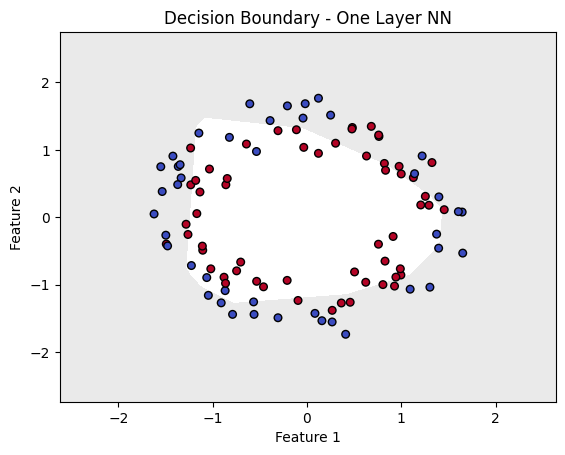

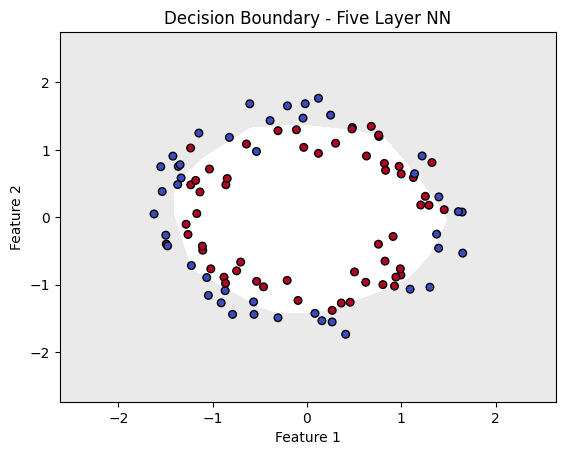

In [ ]:
plot_decision_boundary(model_one, input_test.numpy(), label_test.numpy(), title="Decision Boundary - One Layer NN")
plot_decision_boundary(model_five, input_test.numpy(), label_test.numpy(), title="Decision Boundary - Five Layer NN")